In [1]:
pip install shap


   ---------------------------------------- 0.0/547.0 kB ? eta -:--:--
   -------------------------------------- - 524.3/547.0 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 547.0/547.0 kB 3.6 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------------- -------------------- 1.3/2.7 MB 7.4 MB/s eta 0:00:01
   -------------------------------------- - 2.6/2.7 MB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 6.1 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   - -------------------------------------- 1.0/38.1 MB 7.1 MB/s eta 0:00:06
   -- ------------------------------------- 2.4/38.1 MB 6.1 MB/s eta 0:00:06
   ---- ----------------------------------- 3.9/38.1 MB 6.3 MB/s eta 0:00:06
   ----- ---------------------------------- 5.0/38.1 MB 6.3 MB/s eta 0:00:06
   ------ --------------------------------- 6.6/38.1 MB 6.3 MB/s eta 0:00:06
   -------- -----------

In [1]:
import pandas as pd
import numpy as np

import shap
import matplotlib.pyplot as plt


c:\Users\SAKSHI  A S\pose-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.ensemble import RandomForestRegressor

# Load clean data
df = pd.read_csv(
    "../data/ml_ready_dataset_clean.csv",
    parse_dates=["from_date"]
)

# Sort by time
df = df.sort_values("from_date").reset_index(drop=True)

TARGET = "PM2.5"
non_features = ["from_date", "station_id"]

X = df.drop(columns=non_features + [TARGET])
y = df[TARGET]

# Time-aware split
split_idx = int(0.8 * len(df))

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# Train baseline RF again
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [3]:
explainer = shap.TreeExplainer(rf)


In [4]:
# Use a sample for speed
X_sample = X_test.sample(1000, random_state=42)

shap_values = explainer.shap_values(X_sample)


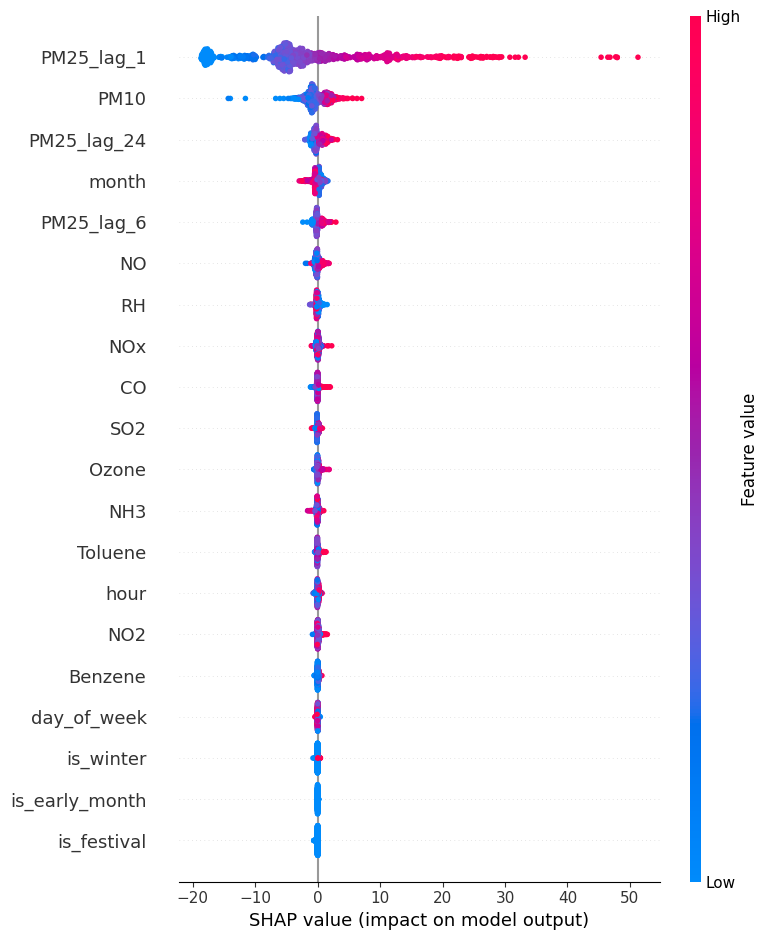

In [5]:
shap.summary_plot(shap_values, X_sample)


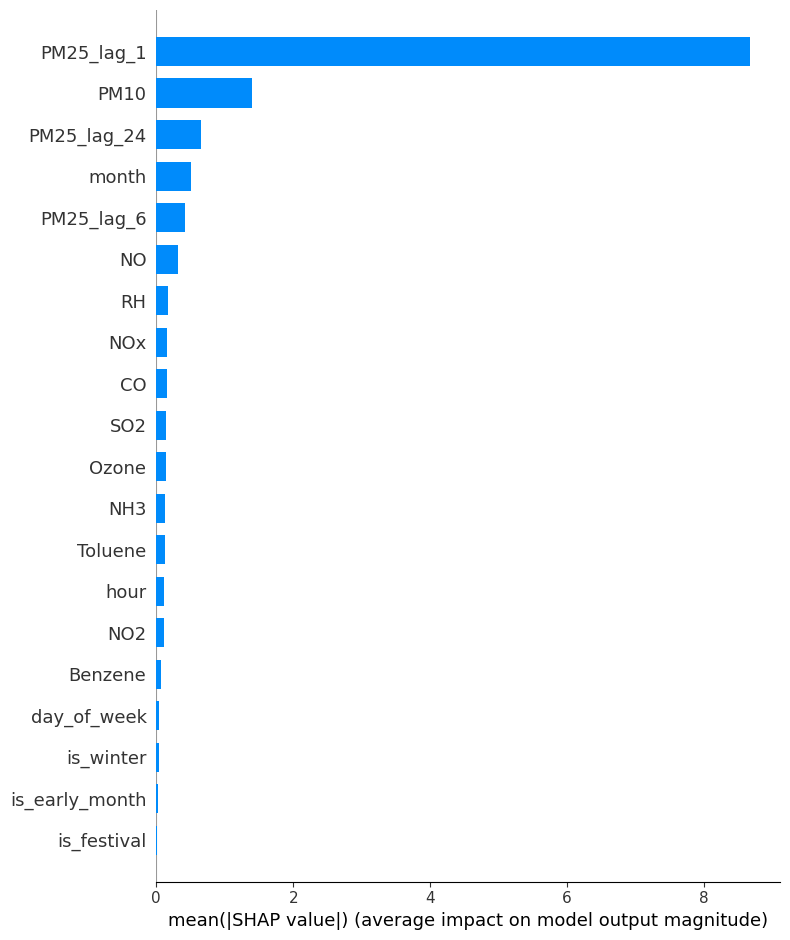

In [6]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")


In [7]:
idx = 10  # any index you like
x_instance = X_test.iloc[[idx]]

prediction = rf.predict(x_instance)[0]
actual = y_test.iloc[idx]

print("Predicted PM2.5:", round(prediction, 2))
print("Actual PM2.5   :", round(actual, 2))


Predicted PM2.5: 18.71
Actual PM2.5   : 17.5


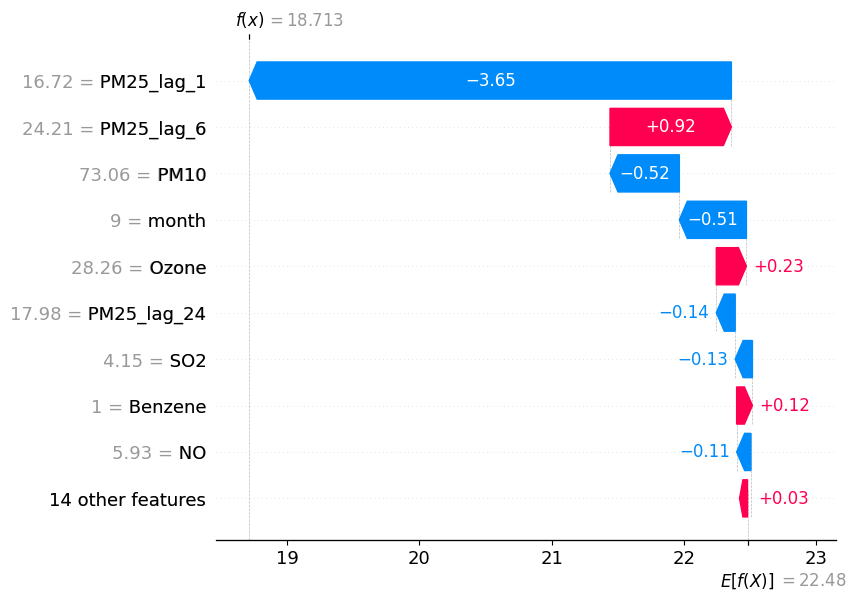

In [8]:
shap.waterfall_plot(
    shap.Explanation(
        values=explainer.shap_values(x_instance)[0],
        base_values=explainer.expected_value,
        data=x_instance.iloc[0],
        feature_names=X.columns
    )
)


In [10]:
print("Festival rows in test set:",
      (X_test["is_festival"] == 1).sum())

print("Non-festival rows in test set:",
      (X_test["is_festival"] == 0).sum())


Festival rows in test set: 0
Non-festival rows in test set: 4236


In [11]:
# Festival cases from training data
festival_train = X_train[X_train["is_festival"] == 1]

print("Festival rows in training set:", len(festival_train))


Festival rows in training set: 188


In [12]:
n_festival = min(300, len(festival_train))
festival_cases = festival_train.sample(n=n_festival, random_state=42)

shap_festival = explainer.shap_values(festival_cases)


In [13]:
non_festival_train = X_train[X_train["is_festival"] == 0]
non_festival_cases = non_festival_train.sample(n=300, random_state=42)

shap_non_festival = explainer.shap_values(non_festival_cases)


In [14]:
feat_idx = X.columns.get_loc("is_festival")

festival_impact = shap_festival[:, feat_idx].mean()
non_festival_impact = shap_non_festival[:, feat_idx].mean()

print("Avg SHAP impact (festival):", round(festival_impact, 3))
print("Avg SHAP impact (non-festival):", round(non_festival_impact, 3))


Avg SHAP impact (festival): 0.3
Avg SHAP impact (non-festival): -0.004
